In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

In [70]:
stop_22_df = pd.read_csv('../stop22.csv')
stop_22_df.dropna(subset=['HDWY_DEV', 'ADHERENCE'], inplace=True)
stop_22_df.head()
original_nan_count = stop_22_df['HDWY_DEV'].isna().sum()
print(f"Number of NaN values in the original dataset: {original_nan_count}")


Number of NaN values in the original dataset: 0


In [71]:
# Create a deep copy of the sliced dataframe
stop_22_df_copy = stop_22_df.copy()
# Create a unique identifier combining TRIP_ID and CALENDAR_ID
stop_22_df_copy['TRIP_CALENDAR_ID'] = stop_22_df_copy['TRIP_ID'].astype(str) + "_" + stop_22_df_copy['CALENDAR_ID'].astype(str)

In [72]:
# Sample a few unique trips from the dataframe
sampled_trip_calendar_ids_for_inspection = np.random.choice(stop_22_df_copy['TRIP_CALENDAR_ID'].unique(), 3)

# Extract and display the BLOCK_STOP_ORDER values for these trips
block_stop_order_samples = [stop_22_df_copy[stop_22_df_copy['TRIP_CALENDAR_ID'] == trip_id][['TRIP_CALENDAR_ID', 'BLOCK_STOP_ORDER', 'SCHEDULED_TIME']]
                           for trip_id in sampled_trip_calendar_ids_for_inspection]

block_stop_order_samples


[       TRIP_CALENDAR_ID  BLOCK_STOP_ORDER SCHEDULED_TIME
 24905  350129_120230928                55       10:35:00
 24906  350129_120230928                70       10:46:00,
        TRIP_CALENDAR_ID  BLOCK_STOP_ORDER SCHEDULED_TIME
 11057  350076_120230826               227       09:01:00
 11058  350076_120230826               243       09:10:00
 11059  350076_120230826               251       09:17:00
 11060  350076_120230826               263       09:25:00,
       TRIP_CALENDAR_ID  BLOCK_STOP_ORDER SCHEDULED_TIME
 6307  350218_120230815               197       10:44:00
 6308  350218_120230815               200       10:47:00]

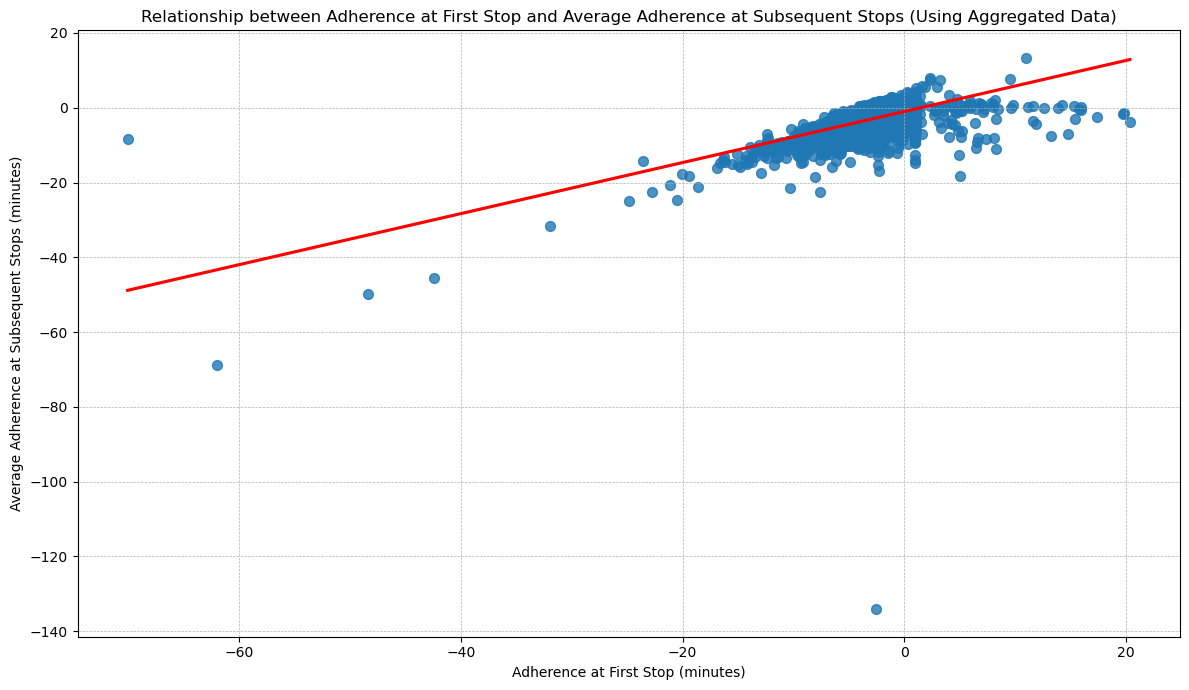

In [73]:
# Aggregate adherence values for the first stop and average adherence for subsequent stops based on the unique identifier
first_stop_adherence_agg = stop_22_df_copy[stop_22_df_copy['TRIP_EDGE'] == 1].groupby('TRIP_CALENDAR_ID')['ADHERENCE'].mean()
avg_subsequent_adherence_agg = stop_22_df_copy[stop_22_df_copy['TRIP_EDGE'] != 1].groupby('TRIP_CALENDAR_ID')['ADHERENCE'].mean()

# Synchronize the two aggregated series by their unique identifiers
agg_adherence_data = pd.concat([first_stop_adherence_agg, avg_subsequent_adherence_agg], axis=1, keys=['First_Stop_Adherence', 'Avg_Subsequent_Adherence']).dropna()

# Create the scatter plot using the aggregated data
plt.figure(figsize=(12, 7))
sns.regplot(x=agg_adherence_data['First_Stop_Adherence'], y=agg_adherence_data['Avg_Subsequent_Adherence'], scatter_kws={'s':50}, line_kws={'color':'red'}, ci=None)
plt.xlabel('Adherence at First Stop (minutes)')
plt.ylabel('Average Adherence at Subsequent Stops (minutes)')
plt.title('Relationship between Adherence at First Stop and Average Adherence at Subsequent Stops (Using Aggregated Data)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


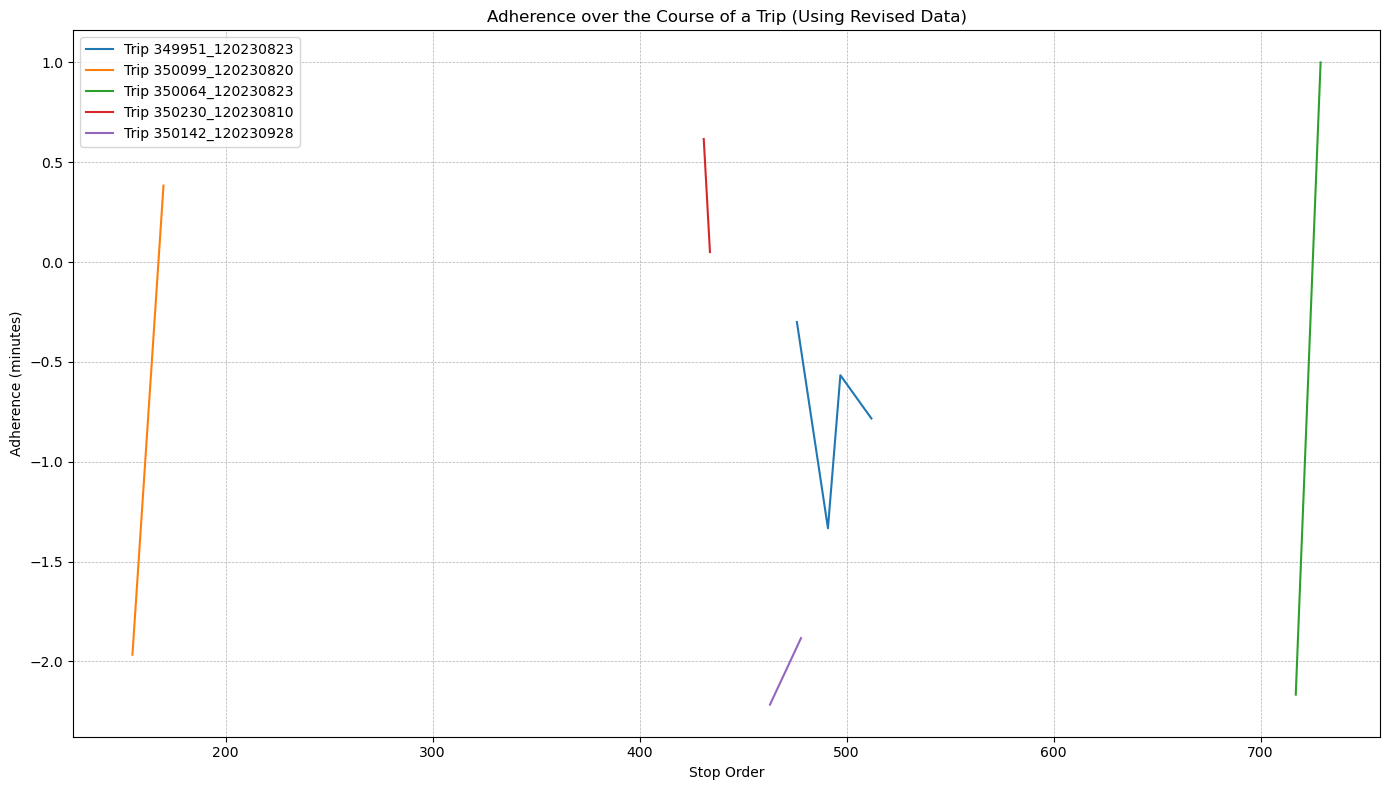

In [74]:
# Select a few random trips (using the unique identifier) for visualization
sample_trip_calendar_ids = agg_adherence_data.index.unique()
selected_trip_calendar_ids = np.random.choice(sample_trip_calendar_ids, 5, replace=False)

# Plot adherence values for the selected trips
plt.figure(figsize=(14, 8))

for trip_calendar_id in selected_trip_calendar_ids:
    trip_data = stop_22_df[stop_22_df_copy['TRIP_CALENDAR_ID'] == trip_calendar_id]
    plt.plot(trip_data['BLOCK_STOP_ORDER'], trip_data['ADHERENCE'], label=f'Trip {trip_calendar_id}')

plt.xlabel('Stop Order')
plt.ylabel('Adherence (minutes)')
plt.title('Adherence over the Course of a Trip (Using Revised Data)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



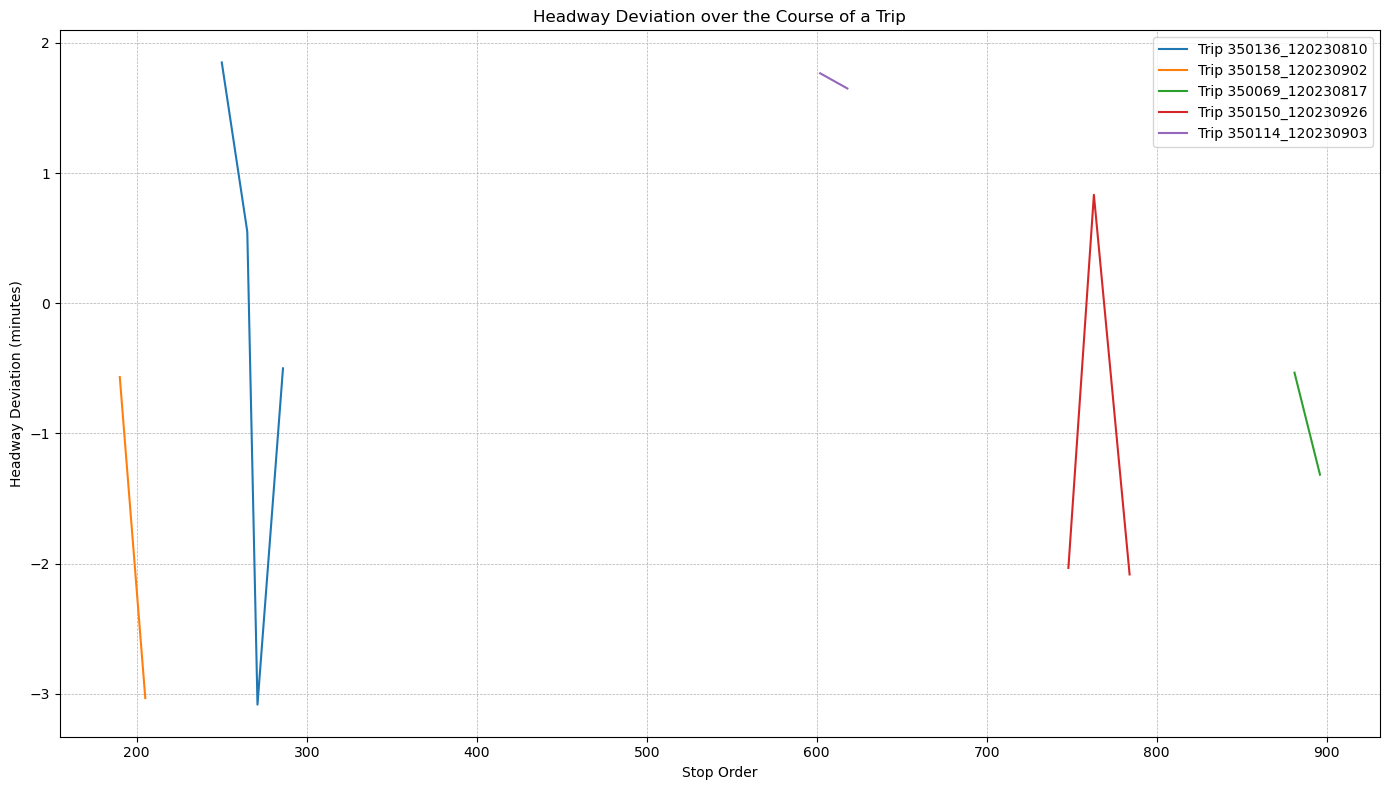

In [75]:
# Select a few random trips (using the unique identifier) from the corrected dataframe for visualization
selected_trip_calendar_ids_hdwy = np.random.choice(sample_trip_calendar_ids, 5, replace=False)

# Plot headway deviation values for the selected trips using the corrected dataframe
plt.figure(figsize=(14, 8))

for trip_calendar_id in selected_trip_calendar_ids_hdwy:
    trip_data = stop_22_df_copy[stop_22_df_copy['TRIP_CALENDAR_ID'] == trip_calendar_id]
    plt.plot(trip_data['BLOCK_STOP_ORDER'], trip_data['HDWY_DEV'], label=f'Trip {trip_calendar_id}')

plt.xlabel('Stop Order')
plt.ylabel('Headway Deviation (minutes)')
plt.title('Headway Deviation over the Course of a Trip')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


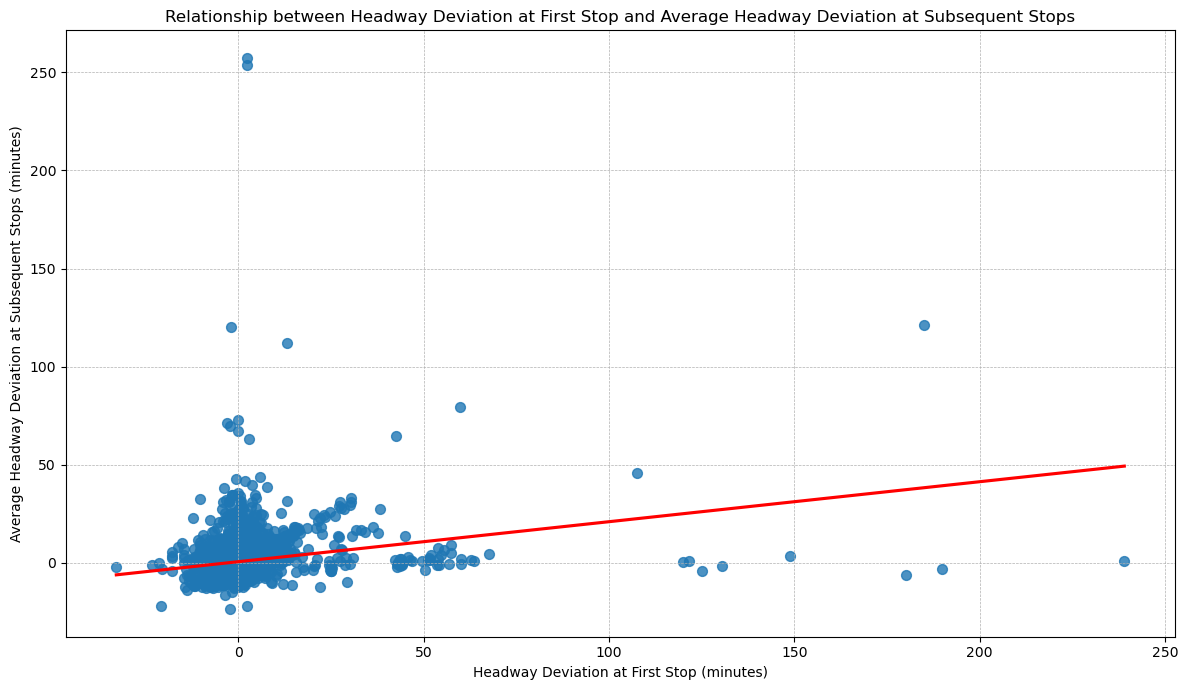

In [76]:
# Calculate headway deviation at the first stop and average headway deviation for subsequent stops using the unique identifier
first_stop_hdwy_dev = stop_22_df_copy[stop_22_df_copy['TRIP_EDGE'] == 1].groupby('TRIP_CALENDAR_ID')['HDWY_DEV'].mean()
avg_subsequent_hdwy_dev = stop_22_df_copy[stop_22_df_copy['TRIP_EDGE'] != 1].groupby('TRIP_CALENDAR_ID')['HDWY_DEV'].mean()

# Synchronize the two aggregated series by their unique identifiers
synced_hdwy_data = pd.concat([first_stop_hdwy_dev, avg_subsequent_hdwy_dev], axis=1, keys=['First_Stop_HDWY_DEV', 'Avg_Subsequent_HDWY_DEV']).dropna()

# Create the scatter plot for headway deviation using the aggregated data
plt.figure(figsize=(12, 7))
sns.regplot(x=synced_hdwy_data['First_Stop_HDWY_DEV'], y=synced_hdwy_data['Avg_Subsequent_HDWY_DEV'], scatter_kws={'s':50}, line_kws={'color':'red'}, ci=None)
plt.xlabel('Headway Deviation at First Stop (minutes)')
plt.ylabel('Average Headway Deviation at Subsequent Stops (minutes)')
plt.title('Relationship between Headway Deviation at First Stop and Average Headway Deviation at Subsequent Stops')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [77]:
# Calculate correlation between headway deviation at the first stop and average headway deviation of subsequent stops
hdwy_correlation = synced_hdwy_data['First_Stop_HDWY_DEV'].corr(synced_hdwy_data['Avg_Subsequent_HDWY_DEV'])

hdwy_correlation


0.22371813554460424

In [78]:
# Calculate correlation adherence at first stop and average adherence at subsequent stops
adherence_correlation =  agg_adherence_data['First_Stop_Adherence'].corr(agg_adherence_data['Avg_Subsequent_Adherence'])

adherence_correlation


0.5910656000819888

In [79]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points 
    on the Earth's surface given their latitude and longitude 
    in decimal degrees.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    r = 6371  # Radius of Earth in kilometers
    distance = r * c
    return distance

In [80]:
# Define a function to compute the haversine distance for each group (trip)
def compute_distance_for_group(group):
    group['DISTANCE'] = group.apply(
        lambda x: haversine_distance(
            x['LATITUDE'], x['LONGITUDE'], 
            x['PREV_LATITUDE'], x['PREV_LONGITUDE']
        ) if not (pd.isna(x['PREV_LATITUDE']) or pd.isna(x['PREV_LONGITUDE'])) else 0,
        axis=1
    )
    return group


In [81]:

# Sort the dataframe by 'TRIP_CALENDAR_ID' and 'BLOCK_STOP_ORDER' for sequential processing
stop_22_df_copy_sorted = stop_22_df_copy.sort_values(by=['TRIP_CALENDAR_ID', 'BLOCK_STOP_ORDER'])


# Add previous stop latitude and longitude for each row
stop_22_df_copy_sorted['PREV_LATITUDE'] = stop_22_df_copy_sorted.groupby('TRIP_CALENDAR_ID')['LATITUDE'].shift(1)
stop_22_df_copy_sorted['PREV_LONGITUDE'] = stop_22_df_copy_sorted.groupby('TRIP_CALENDAR_ID')['LONGITUDE'].shift(1)

# Compute the distance for each group (trip)
stop_22_df_copy_sorted = stop_22_df_copy_sorted.groupby('TRIP_CALENDAR_ID').apply(compute_distance_for_group)

stop_22_df_copy_sorted = stop_22_df_copy_sorted.reset_index(drop=True)
# Compute the cumulative distance traveled since the start of the trip
stop_22_df_copy_sorted['CUMULATIVE_DISTANCE'] = stop_22_df_copy_sorted.groupby('TRIP_CALENDAR_ID')['DISTANCE'].cumsum()

stop_22_df_copy_sorted[['TRIP_CALENDAR_ID', 'BLOCK_STOP_ORDER', 'DISTANCE', 'CUMULATIVE_DISTANCE', 'HDWY_DEV']].head(10)

# original_nan_count = stop_22_df_copy_sorted['HDWY_DEV'].isna().sum()
# print(f"Number of NaN values in the original dataset: {original_nan_count}")


,TRIP_CALENDAR_ID,BLOCK_STOP_ORDER,DISTANCE,CUMULATIVE_DISTANCE,HDWY_DEV
0,345106_120230801,63,0.000000,0.000000,2.666666
1,345106_120230801,70,1.524015,1.524015,1.966666
2,345106_120230801,80,2.612329,4.136344,-0.483334
3,345106_120230802,63,0.000000,0.000000,1.983333
4,345106_120230802,70,1.524015,1.524015,1.900000
5,345106_120230802,80,2.612329,4.136344,-2.850000
6,345106_120230803,63,0.000000,0.000000,4.266666
7,345106_120230803,70,1.524015,1.524015,2.916666
8,345106_120230803,80,2.612329,4.136344,2.666666
9,345107_120230801,97,0.000000,0.000000,-2.166667


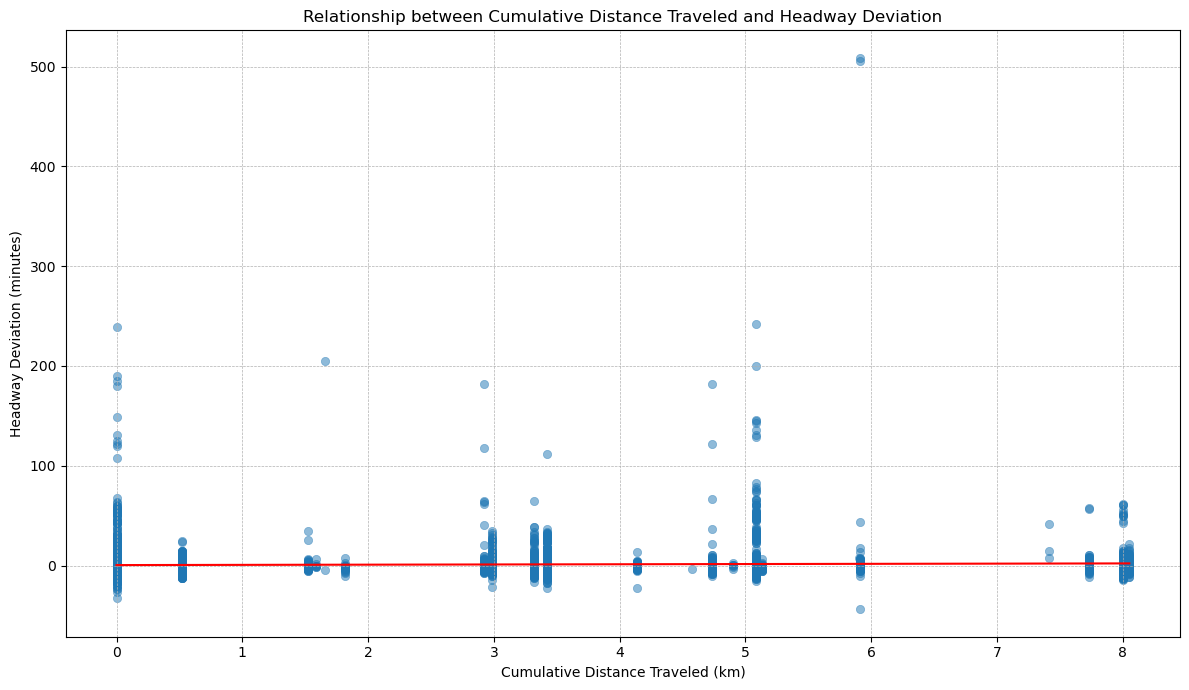

In [82]:
# Visualization of the relationship between cumulative distance traveled and headway deviation

plt.figure(figsize=(12, 7))
sns.scatterplot(data=stop_22_df_copy_sorted, x="CUMULATIVE_DISTANCE", y="HDWY_DEV", alpha=0.5, edgecolor=None)
sns.regplot(data=stop_22_df_copy_sorted, x="CUMULATIVE_DISTANCE", y="HDWY_DEV", scatter=False, color="red", line_kws={'linewidth':1.5})
plt.title("Relationship between Cumulative Distance Traveled and Headway Deviation")
plt.xlabel("Cumulative Distance Traveled (km)")
plt.ylabel("Headway Deviation (minutes)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [83]:
# Calculate the correlation coefficient between cumulative distance traveled and headway deviation
correlation_coefficient = stop_22_df_copy_sorted['CUMULATIVE_DISTANCE'].corr(stop_22_df_copy_sorted['HDWY_DEV'])

correlation_coefficient


0.04744583286105831